In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
from car_dqn import CarRacingDQN
from IPython.display import clear_output
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import gym
import _thread
import re
import sys
import numpy as np
import racing_car
import keyboard

In [2]:
train_episodes = 15000
save_freq_episodes = train_episodes/100 
finished = False
render_var = False
frame_skip = 3

# This initializes the CNN.
model_config = dict(
    min_epsilon=0.05,
    max_negative_rewards=8,
    min_experience_size=int(100),
    experience_capacity=int(150000),
    num_frame_stack=frame_skip,
    frame_skip=frame_skip,
    train_freq=frame_skip,
    batchsize=64,
    epsilon_decay_steps=int(100000),
    target_network_update_freq=int(1000), #Updates the target network every 10000 global steps by copying them from the prediction network to the target network
    gamma=0.95,
    render=render_var,
)

dqn_scores = []
eps_history = []
avg_score_all = [0]

env = racing_car.CarRacing()

tf.compat.v1.reset_default_graph
tf.compat.v1.disable_eager_execution()

dqn_agent = CarRacingDQN(env=env, **model_config)
dqn_agent.build_graph()
sess = tf.compat.v1.InteractiveSession()
dqn_agent.session = sess
clear_output()

In [3]:
load_checkpoint = False
checkpoint_path = "March11_checkpoints/train_3" # 2 is a good 13000 episode training session
opendir = checkpoint_path + '.txt'
rewards_checkpoint_file = 'March11_checkpoints/rewards/'
if load_checkpoint:
    text_results = open(opendir, "w")

#Initialize save checkpoints
saver = tf.compat.v1.train.Saver(max_to_keep=1000) #max number of checkpoints = 500
#Choice to load checkpoints
if load_checkpoint:
    train_episodes = 110
    save_freq_episodes = 0
    print("loading the latest checkpoint from %s" % checkpoint_path)
    ckpt = tf.train.get_checkpoint_state(checkpoint_path)
    assert ckpt, "checkpoint path %s not found" % checkpoint_path
    global_counter = int(re.findall("-(\d+)$", ckpt.model_checkpoint_path)[0])
    saver.restore(sess, ckpt.model_checkpoint_path)
    dqn_agent.global_counter = global_counter
    render = render_var
else:
    if checkpoint_path is not None:
        assert not os.path.exists(checkpoint_path), \
            "checkpoint path already exists but load_checkpoint is false"

    tf.compat.v1.global_variables_initializer().run()

    
def save_checkpoint():
    if not os.path.exists(checkpoint_path):
        os.makedirs(checkpoint_path)
    p = os.path.join(checkpoint_path, "m.ckpt")
    saver.save(sess, p, dqn_agent.global_counter)
    print("saved to %s - %d" % (p, dqn_agent.global_counter))


def one_episode(eps_history,dqn_scores,avg_score_all,render,load_checkpoint):
    score, reward, frames, epsilon = dqn_agent.play_episode(render, load_checkpoint)

    eps_history.append(epsilon)

    dqn_scores.append(score)
    i = dqn_agent.episode_counter
    avg_score = np.mean(dqn_scores[max(0, i - 100):(i + 1)])
    avg_score_all.append(avg_score)
    max_avg_score = max(avg_score_all)
    if avg_score >= max_avg_score:
        new_max = ' => New HighScore! <= '
        highscore = True
    else:
        new_max = ''
        highscore = False

    strm = ("#> episode: %i | score: %.2f | total steps: %i | epsilon: %.5f | average 100 score: %.2f" %
            (i, score, dqn_agent.global_counter, epsilon, avg_score))

    print(strm + new_max)

    text_results = open(opendir, "a")
    text_results.write(strm + new_max + '\n')
    text_results.close()

    if not load_checkpoint:
        save_cond = (
            dqn_agent.episode_counter % save_freq_episodes == 0
            and checkpoint_path is not None
            and dqn_agent.do_training
        )
        if save_cond or (highscore and dqn_agent.episode_counter > 100):
            save_checkpoint()

    return eps_history,dqn_scores,avg_score_all

def input_thread(list):
    input("...enter to stop after current episode\n")
    list.append("OK")


def main_loop(eps_history,dqn_scores,avg_score_all,render,load_checkpoint):
    while True:
        if dqn_agent.do_training and dqn_agent.episode_counter >= train_episodes:
            print('break2')
            break

        if keyboard.is_pressed('q'):
            break

        print(dqn_agent.episode_counter)

        if (dqn_agent.episode_counter + 1) % 100 == 0:
            dqn_agent.env.close()
            dqn_agent.env = racing_car.CarRacing()
            print('##'*30)
            print('TEST FULL RESET Environment')
            print('##'*30)

        eps_history,dqn_scores,avg_score_all = one_episode(eps_history,dqn_scores,avg_score_all,render,load_checkpoint)

        if (dqn_agent.episode_counter + 1) % 10 == 0:   
            print('... saving rewards history ...')

            #===================================Episode Reward========================
            name = 'episode_reward_train_3'
            episode_reward_name = os.path.join(rewards_checkpoint_file, name+'.txt')
            episode_rewards_file = open(episode_reward_name, 'w')
            for row in np.array(dqn_scores).reshape(len(dqn_scores),1):
                np.savetxt(episode_rewards_file, row)
            episode_rewards_file.close()

            #====================================AVG Reward========================
            name = 'avg_reward_train_3'
            avg_reward_name = os.path.join(rewards_checkpoint_file, name+'.txt')
            avg_rewards_file = open(avg_reward_name, 'w')
            for row in np.array(avg_score_all).reshape(len(avg_score_all),1):
                np.savetxt(avg_rewards_file, row)
            avg_rewards_file.close()



    print("done")
    text_results.close()
    exit()
    return eps_history,dqn_scores,avg_score_all

    
# if train_episodes > 0 and dqn_agent.episode_counter < train_episodes:
#     print("now training... you can early stop with enter...")
#     print("##########")
#     sys.stdout.flush()
#     render = render_var
#     main_loop(eps_history,dqn_scores,avg_score_all,render,load_checkpoint)
#     save_checkpoint()
#     dqn_agent.env.close()
#     print("ok training done")

    
if train_episodes > 0 and dqn_agent.episode_counter < train_episodes and not load_checkpoint :
    print("now training... you can early stop with enter...")
    print("##########")
    sys.stdout.flush()
    render = render_var
    main_loop(eps_history,dqn_scores,avg_score_all,render,load_checkpoint)
    save_checkpoint()
    print("ok training done")
    
else:
    print("now just playing...")
    sys.stdout.flush()
    main_loop(eps_history,dqn_scores,avg_score_all,render,load_checkpoint)
    plt.imshow(dqn_agent.env.state.T)

: 559.85
6198
Track generation: 953..1202 -> 249-tiles track
#> episode: 6199 | score: 914.07 | total steps: 895029 | epsilon: 0.05000 | average 100 score: 566.08
... saving rewards history ...
6199
############################################################
TEST FULL RESET Environment
############################################################
Track generation: 1122..1406 -> 284-tiles track
#> episode: 6200 | score: 893.86 | total steps: 895265 | epsilon: 0.05000 | average 100 score: 575.01
6200
Track generation: 1246..1562 -> 316-tiles track
#> episode: 6201 | score: 265.71 | total steps: 895374 | epsilon: 0.05000 | average 100 score: 568.87
6201
Track generation: 978..1234 -> 256-tiles track
#> episode: 6202 | score: 894.48 | total steps: 895595 | epsilon: 0.05000 | average 100 score: 575.30
6202
Track generation: 1055..1323 -> 268-tiles track
#> episode: 6203 | score: 5.24 | total steps: 895615 | epsilon: 0.05000 | average 100 score: 570.60
6203
Track generation: 1140..1429 -> 28

NameError: name 'text_results' is not defined

In [7]:
dqn_agent.do_training, dqn_agent.episode_counter, train_episodes, list

(True, 1, 15000, list)

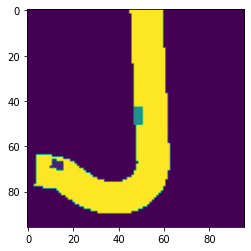

In [4]:
plt.imshow(dqn_agent.env.state.T)

In [ ]:
plt.figure(0,figsize = (10,5))
plt.plot(dqn_scores,'k',label = 'Independent episode scores')
plt.plot(avg_score_all,'r--', label = '100 episode moving average score')
plt.plot([0,110],[900,900],'g',label = 'Open AI performance indicator')
plt.ylabel('$\mathcal{R}$')
plt.xlabel('Episodes')
plt.grid()
plt.ylim(-10,1000)
plt.legend()

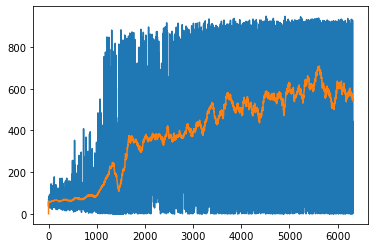

In [4]:
plt.plot(dqn_scores)
plt.plot(avg_score_all)

In [6]:
array = np.loadtxt('March11_checkpoints/rewards/avg_reward_train_3.txt')

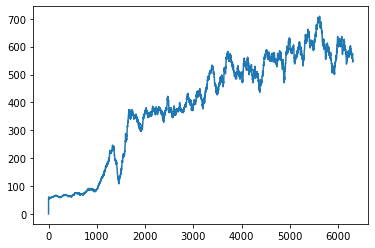

In [8]:
plt.plot(array)

In [ ]:
plt.plot(dqn_scores)
plt.plot(avg_score_all)

In [10]:
x = 4
assert x>5 
print('through')

AssertionError: 